In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
from itertools import product
import seaborn as sns

from main import *

SAVE_PATH = r"./data"

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

In [40]:
# 注意，需要保持以下参数和 multiRun.py 中的参数一致，并且先允许运行 multiRun.py 生成数据，
# 否则后面画图程序会因为没有数据而报错

# 这是扫描的噪声强度范围, 相当于图片的横坐标
alphaRanges = [0, 0.5, 1.0, 1.5, 2.0]  # 空间噪声强度 alpha 的参数范围
betaRanges = [0, 0.5, 1.0, 1.5, 2.0]   # 相位噪声强度 beta 的参数范围

# 这里耦合强度和耦合距离是固定的, 只改变噪声强度, 如果需要尝试别的参数, 可以在这里手动修改
models = [
    ChiralActiveMatterWithNoise(
        strengthLambda=0.95,   # 耦合强度 lambda
        distanceD0=2,          # 耦合距离 D0
        noiseRateAlpha=alpha,  # 空间噪声强度 alpha
        noiseRateBeta=beta,    # 相位噪声强度 beta
        savePath=SAVE_PATH,    # 保存路径
        overWrite=True         # 是否覆盖已有缓存
    )
    for alpha in alphaRanges
    for beta in betaRanges
]

# R

In [42]:
# 计算序参量 R
def calc_rail_mean_R(model: ChiralActiveMatterWithNoise):
    sa = StateAnalysis(model)
    totalPhaseTheta = sa.totalPhaseTheta

    RPool = []
    lookIdxs = np.arange(-601, 0, 3)
    for idx in lookIdxs:
        lastPhaseTheta = totalPhaseTheta[idx]
        RPool.append(StateAnalysis._clac_phase_sync_op(lastPhaseTheta))

    return np.mean(RPool)

Rs = dict()

for model in tqdm(models):
    R = calc_rail_mean_R(model)
    Rs[model] = R

  0%|          | 0/25 [00:00<?, ?it/s]

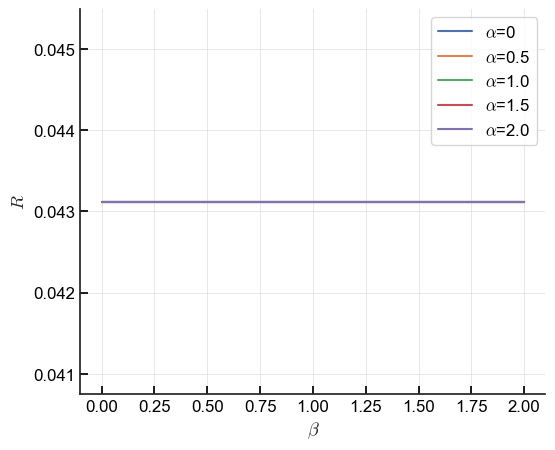

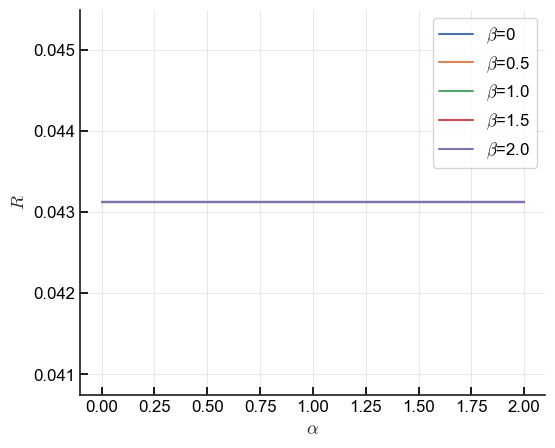

In [43]:
for alpha in alphaRanges:
    subModels = [model for model in models if model.noiseRateAlpha == alpha]
    subRs = [Rs[model] for model in subModels]
    plt.plot(betaRanges, subRs, label=rf"$\alpha$={alpha}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\beta$")
plt.ylabel(r"$R$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

for beta in betaRanges:
    subModels = [model for model in models if model.noiseRateBeta == beta]
    subRs = [Rs[model] for model in subModels]
    plt.plot(alphaRanges, subRs, label=rf"$\beta$={beta}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$R$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

# Rc

In [ ]:
# 计算序参量 Rc
def calc_rail_mean_Rc(model: ChiralActiveMatterWithNoise):
    sa = StateAnalysis(model)
    totalPositionX = sa.totalPositionX
    totalPhaseTheta = sa.totalPhaseTheta
    totalPointTheta = sa.totalPointTheta

    RcPool = []
    lookIdxs = np.arange(-601, 0, 5)
    for idx in lookIdxs:
        lastPositionX = totalPositionX[idx]
        lastPhaseTheta = totalPhaseTheta[idx]
        lastPointTheta = totalPointTheta[idx]

        centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, model.speedV, model.dt)
        centers = np.mod(centers, 10)
        classes = StateAnalysis._calc_classes(
            centers, 0.3, 
            StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
        )
        counts = 0
        sumR = 0
        for classOcsis in classes:
            if len(classOcsis) <= 5:
                continue
            sumR += StateAnalysis._clac_phase_sync_op(lastPhaseTheta[classOcsis])
            counts += 1

        RcPool.append(sumR / counts)

    return np.mean(RcPool)

Rcs = dict()

for model in models:
    Rc = calc_rail_mean_Rc(model)
    Rcs[model] = Rc

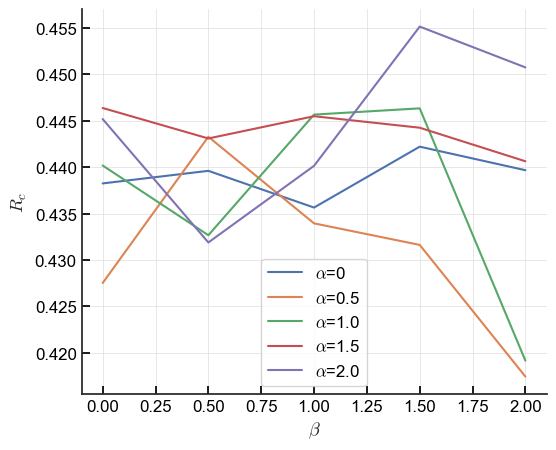

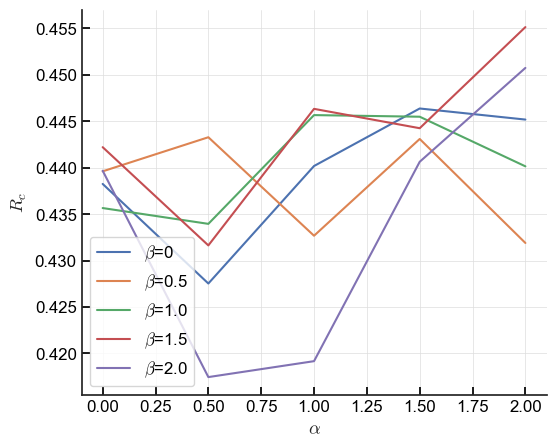

In [35]:
for alpha in alphaRanges:
    subModels = [model for model in models if model.noiseRateAlpha == alpha]
    subRs = [Rcs[model] for model in subModels]
    plt.plot(betaRanges, subRs, label=rf"$\alpha$={alpha}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\beta$")
plt.ylabel(r"$R_c$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

for beta in betaRanges:
    subModels = [model for model in models if model.noiseRateBeta == beta]
    subRs = [Rcs[model] for model in subModels]
    plt.plot(alphaRanges, subRs, label=rf"$\beta$={beta}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$R_c$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

# Delta Omega

In [ ]:
# 计算序参量 Delta Omega
def calc_delta_omega(model):
    sa = StateAnalysis(model, lookIndex=-1)
    totalPointTheta = sa.totalPointTheta
    centers = sa.centers
    classes = StateAnalysis._calc_classes(
        centers, 0.35, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0

    for classOcsis in classes:
        if len(classOcsis) < 5:
            continue
        meanPointTheta = totalPointTheta[-30:, classOcsis].mean(axis=0) / model.dt
        sumR += ((meanPointTheta - meanPointTheta[:, np.newaxis])**2).sum() / len(classOcsis) ** 2
        counts += 1

    return sumR / counts

delta_omegas = dict()

for model in models:
    delta_omega = calc_delta_omega(model)
    delta_omegas[model] = delta_omega

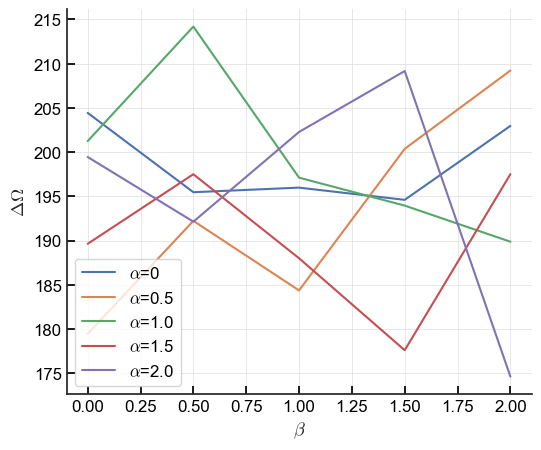

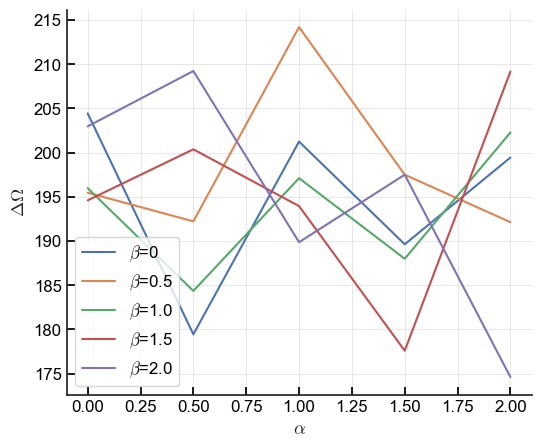

In [34]:
for alpha in alphaRanges:
    subModels = [model for model in models if model.noiseRateAlpha == alpha]
    subRs = [delta_omegas[model] for model in subModels]
    plt.plot(betaRanges, subRs, label=rf"$\alpha$={alpha}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\Delta \Omega$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

for beta in betaRanges:
    subModels = [model for model in models if model.noiseRateBeta == beta]
    subRs = [delta_omegas[model] for model in subModels]
    plt.plot(alphaRanges, subRs, label=rf"$\beta$={beta}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\Delta \Omega$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

In [37]:
# 计算序参量 Nr
def clac_Nr(model: ChiralActiveMatterWithNoise):
    sa = StateAnalysis(model)
    lastPositionX, _, _ = sa.get_state(index=-1)
    centers = lastPositionX
    classes = StateAnalysis._calc_classes(
        centers, 0.4, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    ratios = 0
    for classOcsis in classes:
        if len(classOcsis) < 2:
            continue
        ratios += len(classOcsis) / model.agentsNum
        counts += 1
    return ratios / counts

Nrs = dict()

for model in models:
    Nr = clac_Nr(model)
    Nrs[model] = Nr

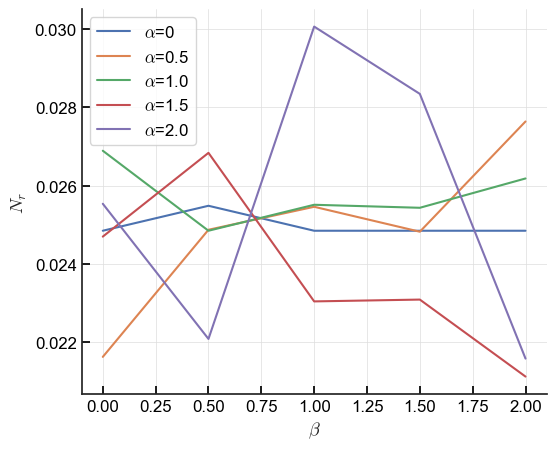

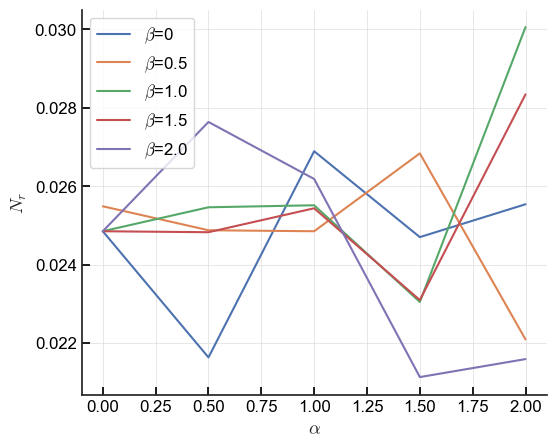

In [38]:
for alpha in alphaRanges:
    subModels = [model for model in models if model.noiseRateAlpha == alpha]
    subRs = [Nrs[model] for model in subModels]
    plt.plot(betaRanges, subRs, label=rf"$\alpha$={alpha}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\beta$")
plt.ylabel(r"$N_r$")
plt.tick_params(direction='in')
plt.legend()
plt.show()

for beta in betaRanges:
    subModels = [model for model in models if model.noiseRateBeta == beta]
    subRs = [Nrs[model] for model in subModels]
    plt.plot(alphaRanges, subRs, label=rf"$\beta$={beta}")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$N_r$")
plt.tick_params(direction='in')
plt.legend()
plt.show()